## Requisitos

In [20]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install nvidia-cudnn-cu12
!pip install Pillow
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

# Rodar um 
# conda install -c conda-forge cudatoolkit

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/vinmelo/Documents/Deep-

## Carregando os dados

### Data Augmentation

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2,
    horizontal_flip = True,
    vertical_flip = True
)
datagen_valid = ImageDataGenerator(
    samplewise_center=True,
    validation_split=0.2
)

2025-07-10 10:45:04.556288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 10:45:04.748787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752155104.836945    9007 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752155104.866189    9007 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752155105.033825    9007 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Para avaliar os diferentes tipos de filtro, vamos carregar o data set de 14 formas:
- Variando cada crop e também sem crop
- Combinado com os dois resizes diferentes

In [3]:
dir_used = ["crop_and_laplacian","crop_and_canny","crop_and_clahe","crop_and_scharr","crop_and_sharpening","crop_only", "removed_bg"]
type_resize = ["proporcional_resize","simple_resize"]


train_dt_proporcional = [datagen_train.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="training",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

valid_dt_proporcional = [datagen_valid.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="validation",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


## Modelo para Side
### Importando o Modelo pré treinado

In [3]:
from tensorflow import keras
base_model = keras.applications.EfficientNetB0(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

I0000 00:00:1752114042.208216   51302 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1403 MB memory:  -> device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:05:00.0, compute capability: 7.5


Congelando as primeiras camadas para treinarmos apenas as camada finais

In [4]:
base_model.trainable = False

### Adicionando camadas e compilando

In [5]:
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1, activation= 'sigmoid')(x)

models = [keras.Model(inputs,outputs) for i in range(7)]
models

[<Functional name=functional, built=True>,
 <Functional name=functional_1, built=True>,
 <Functional name=functional_2, built=True>,
 <Functional name=functional_3, built=True>,
 <Functional name=functional_4, built=True>,
 <Functional name=functional_5, built=True>,
 <Functional name=functional_6, built=True>]

In [6]:
for i in range(7):
    models[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo para cada tipo de imagem

In [7]:
for i in range(7):
    models[i].fit(train_dt_proporcional[i],
          validation_data=valid_dt_proporcional[i],
          epochs=25)

/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1752114080.713403   52295 service.cc:152] XLA service 0x77aa5c002ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752114080.713423   52295 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-07-09 23:21:21.069839: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752114082.754690   52295 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-07-09 23:21:31.670057: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:21:31.863309: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, plea

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - AUC: 0.3947 - Precision: 0.4136 - Recall: 0.3478 - accuracy: 0.4323 - loss: 0.7280

2025-07-09 23:21:48.048347: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:21:48.215062: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:21:48.786031: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:21:48.965958: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:21:49.719256: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.4041 - Precision: 0.4183 - Recall: 0.3560 - accuracy: 0.4347 - loss: 0.7271   

2025-07-09 23:22:06.030901: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:22:06.180695: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:22:06.690587: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:22:06.858606: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:22:07.563939: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - AUC: 0.4104 - Precision: 0.4215 - Recall: 0.3615 - accuracy: 0.4363 - loss: 0.7266 - val_AUC: 0.6651 - val_Precision: 1.0000 - val_Recall: 0.1111 - val_accuracy: 0.5556 - val_loss: 0.6739
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - AUC: 0.5045 - Precision: 0.5135 - Recall: 0.4663 - accuracy: 0.4945 - loss: 0.7071 - val_AUC: 0.6682 - val_Precision: 1.0000 - val_Recall: 0.1111 - val_accuracy: 0.5556 - val_loss: 0.6728
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - AUC: 0.6610 - Precision: 0.6895 - Recall: 0.5031 - accuracy: 0.6391 - loss: 0.6659 - val_AUC: 0.6852 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_accuracy: 0.6667 - val_loss: 0.6632
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - AUC: 0.6615 - Precision: 0.6234 - Recall: 0.6138 - accuracy: 0.6321 - loss: 0.6656 - val_AUC: 0.6790 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_accuracy: 0.6667 - val_loss: 0.6624
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - A

2025-07-09 23:29:29.005109: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:29.169847: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:29.727580: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:29.905829: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:30.636029: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9434 - Precision: 0.7805 - Recall: 0.8939 - accuracy: 0.8304 - loss: 0.3691

2025-07-09 23:29:46.818465: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:46.967907: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:47.119754: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:47.613714: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-09 23:29:47.782000: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - AUC: 0.9392 - Precision: 0.7897 - Recall: 0.8861 - accuracy: 0.8316 - loss: 0.3751 - val_AUC: 0.9183 - val_Precision: 0.8500 - val_Recall: 0.9444 - val_accuracy: 0.8857 - val_loss: 0.3963
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - AUC: 0.9330 - Precision: 0.8105 - Recall: 0.8822 - accuracy: 0.8353 - loss: 0.3788 - val_AUC: 0.9232 - val_Precision: 0.8333 - val_Recall: 0.8333 - val_accuracy: 0.8286 - val_loss: 0.3921
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - AUC: 0.9176 - Precision: 0.8279 - Recall: 0.8562 - accuracy: 0.8416 - loss: 0.3997 - val_AUC: 0.9281 - val_Precision: 0.8333 - val_Recall: 0.8333 - val_accuracy: 0.8286 - val_loss: 0.3868
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - AUC: 0.9313 - Precision: 0.8305 - Recall: 0.9018 - accuracy: 0.8593 - loss: 0.3783 - val_AUC: 0.9314 - val_Precision: 0.8333 - val_Recall: 0.8333 - val_accuracy: 0.8286 - val_loss: 0.3829
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - A

### Avaliando os modelos

#### Acurácia

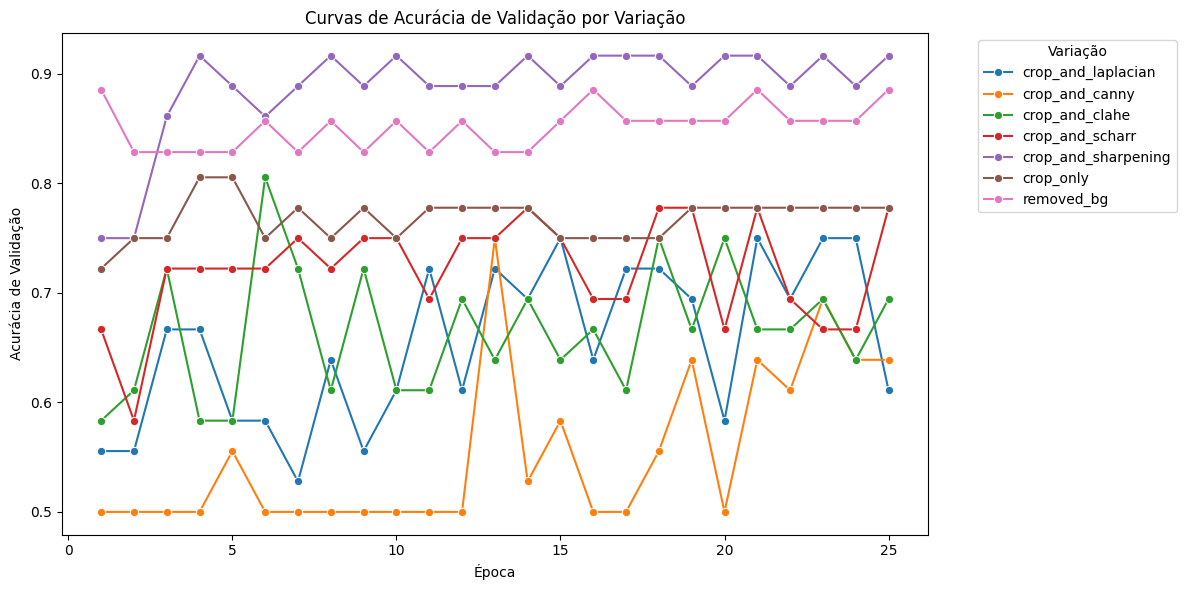

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### AUC (Area under the curve)

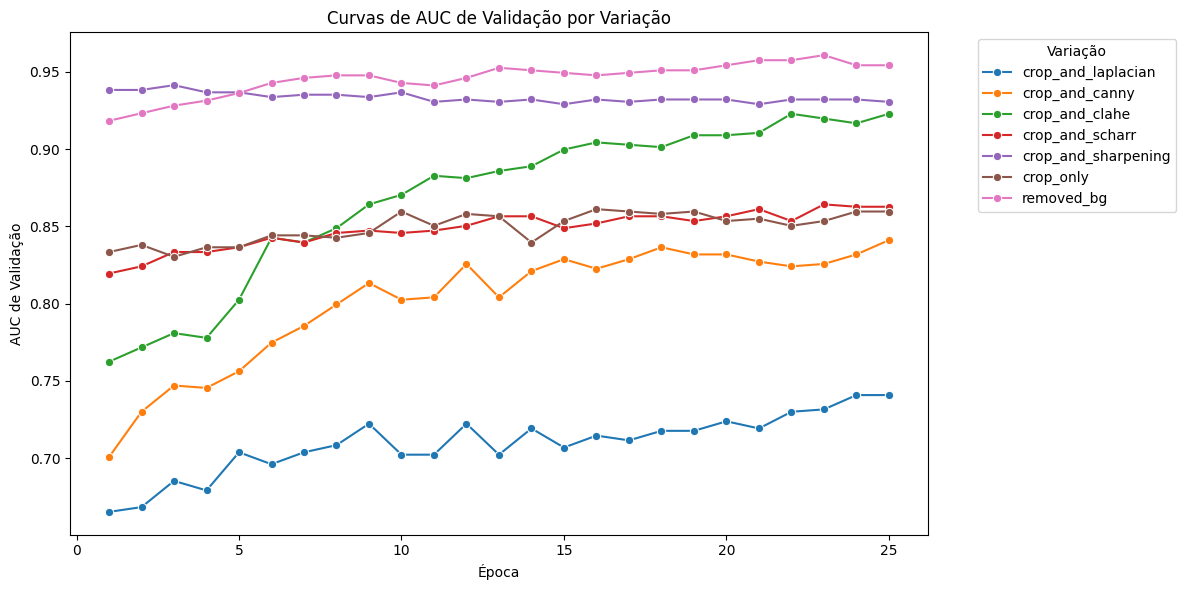

In [11]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de AUC de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("AUC de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Precision

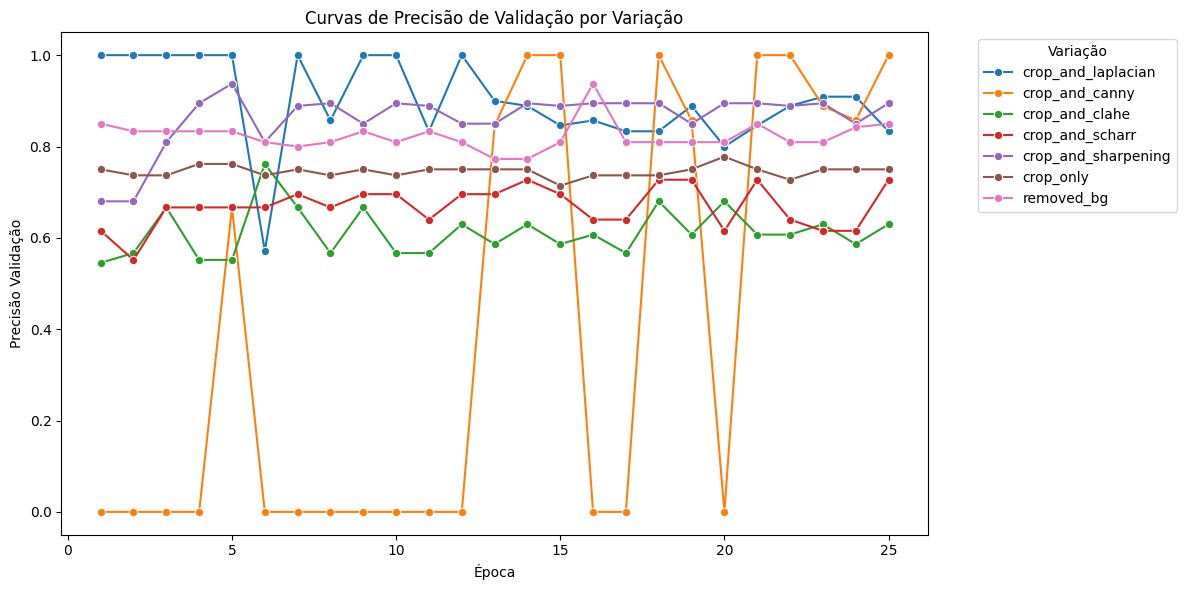

In [12]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Precisão de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Precisão Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Recall

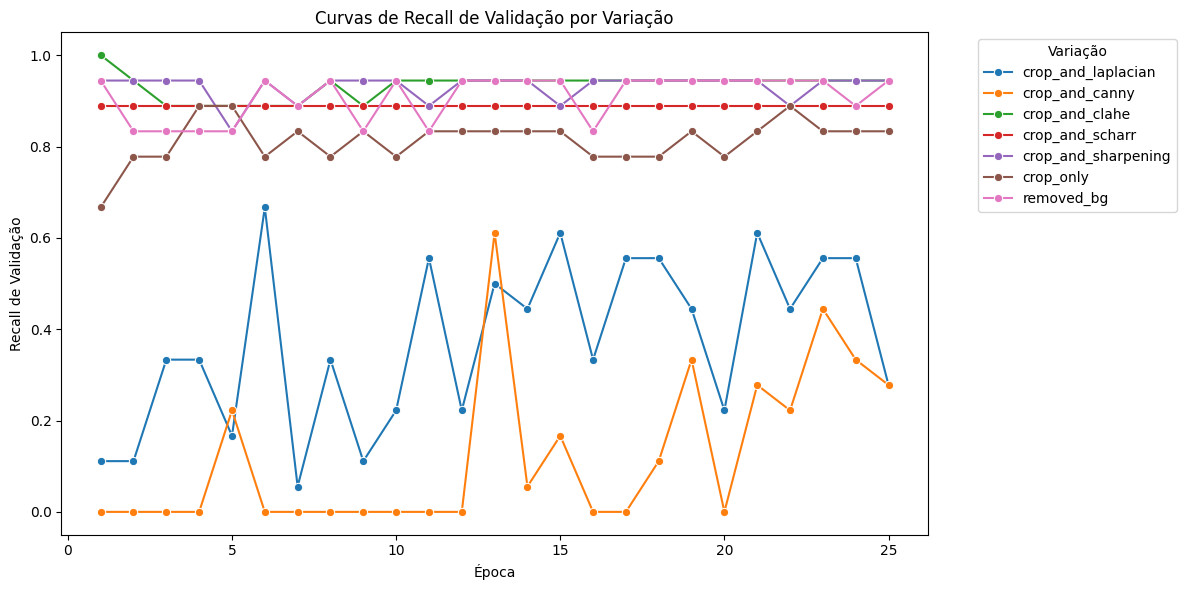

In [13]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Recall de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Recall de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Matriz de confusão

Como o modelo funcionou melhor com crop_and_sharpening, vamos fazer a matriz de confusão
apenas com esse pré processamento

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Carregue o modelo
model_sharpening = load_model('side-sharpening_transfer-learning.keras')

# Use o iterador diretamente (sem slice)
y_pred_probs = model_sharpening.predict(valid_dt_proporcional[4], batch_size=1)
y_pred = (y_pred_probs > 0.5).astype("int").flatten()

# Para pegar os rótulos verdadeiros
y_true = valid_dt_proporcional[4].classes

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752155470.285501   13181 service.cc:152] XLA service 0x7c79c8003610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752155470.285522   13181 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-07-10 10:51:10.411709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752155471.114166   13181 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-07-10 1

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_9007/1459134356.py", line 12, in <module>

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 566, in predict

  File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 260, in one_step_on_data_distributed

CUDNN_STATUS_EXECUTION_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6402): 'status'
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_14400]

In [15]:
models[6].save('side-removed-bg_transfer-learning.keras')
models[4].save('side-sharpening_transfer-learning.keras')

## Modelo para top

### Importando o modelo VGG16

In [22]:
base_model_top = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

base_model_top.trainable = False

### Adicionando camadas e compilando

In [23]:
inputs_top = keras.Input(shape=(224,224,3))

x_top = base_model_top(inputs_top, training=False)
x_top = keras.layers.GlobalAveragePooling2D()(x_top)

outputs_top = keras.layers.Dense(1, activation= 'sigmoid')(x_top)

models_top = [keras.Model(inputs_top,outputs_top) for i in range(7)]
models_top

[<Functional name=functional_14, built=True>,
 <Functional name=functional_15, built=True>,
 <Functional name=functional_16, built=True>,
 <Functional name=functional_17, built=True>,
 <Functional name=functional_18, built=True>,
 <Functional name=functional_19, built=True>,
 <Functional name=functional_20, built=True>]

In [24]:
for i in range(7):
    models_top[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo

In [29]:
for i in range(7):
    models_top[i].fit(train_dt_proporcional[i],
              validation_data=valid_dt_proporcional[i],
              epochs=50)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step - AUC: 0.6032 - Precision: 0.6351 - Recall: 0.1720 - accuracy: 0.5036 - loss: 1.7684 - val_AUC: 0.7006 - val_Precision: 0.5455 - val_Recall: 0.6667 - val_accuracy: 0.5556 - val_loss: 0.9781
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - AUC: 0.6440 - Precision: 0.6268 - Recall: 0.6642 - accuracy: 0.6386 - loss: 0.9580 - val_AUC: 0.7052 - val_Precision: 0.5652 - val_Recall: 0.7222 - val_accuracy: 0.5833 - val_loss: 0.9609
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step - AUC: 0.7305 - Precision: 0.6965 - Recall: 0.6505 - accuracy: 0.6616 - loss: 0.7938 - val_AUC: 0.7068 - val_Precision: 0.6250 - val_Recall: 0.5556 - val_accuracy: 0.6111 - val_loss: 0.9597
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - AUC: 0.6274 - Precision: 0.5309 - Recall: 0.5125 - accuracy: 0.5852 - loss: 0.9926 - val_AUC: 0.7145 - val_Precision: 0.5882 - val_Recall: 0.5556 - val_accuracy: 0.5833 - val_loss: 0.9259
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 5

### Acurácia

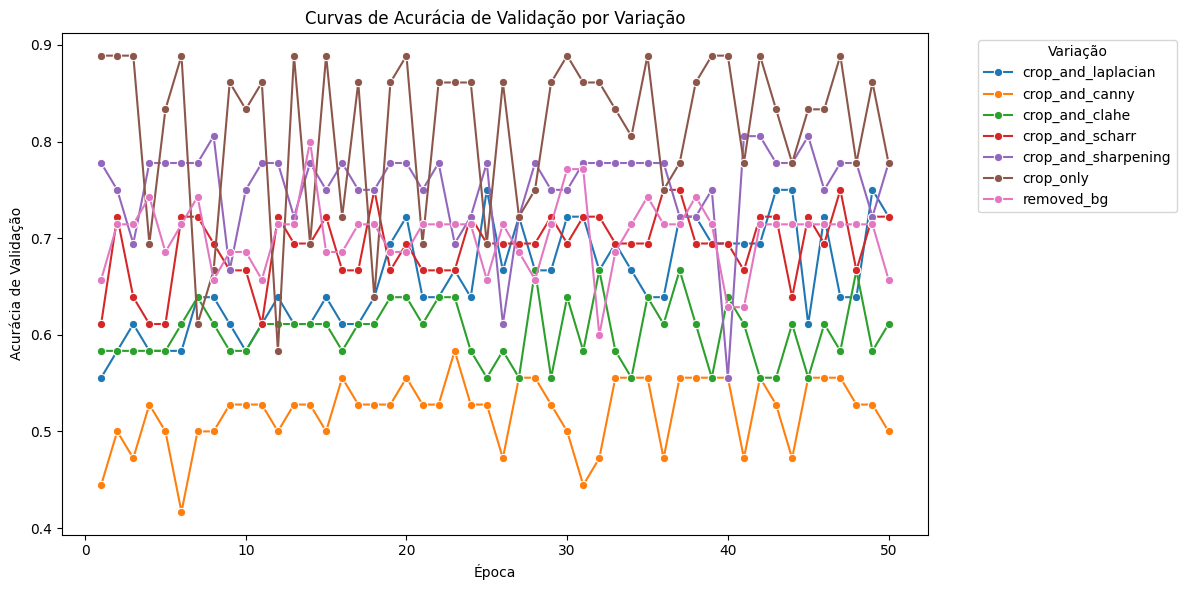

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### AUC

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Precision

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Recall

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
base_model_top.trainable = True

model_top.compile(optimizer=keras.optimizers.RMSprop(learning_rate= 0.00001),
                  loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

model.fit(train_dt_top,
          validation_data=valid_dt_top,
          epochs=20)

Epoch 1/10


36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 324ms/step - AUC: 0.4435 - Precision: 0.4363 - Recall: 0.1813 - accuracy: 0.4586 - loss: 1.4463 - val_AUC: 0.5584 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3611 - val_loss: 0.9781
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - AUC: 0.4313 - Precision: 0.5206 - Recall: 0.3986 - accuracy: 0.5228 - loss: 0.8440 - val_AUC: 0.6234 - val_Precision: 0.5455 - val_Recall: 0.2727 - val_accuracy: 0.4167 - val_loss: 0.7141
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - AUC: 0.4757 - Precision: 0.4620 - Recall: 0.4183 - accuracy: 0.4230 - loss: 0.7418 - val_AUC: 0.6688 - val_Precision: 0.7368 - val_Recall: 0.6364 - val_accuracy: 0.6389 - val_loss: 0.6555
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - AUC: 0.6175 - Precision: 0.5472 - Recall: 0.5731 - accuracy: 0.5494 - loss: 0.6791 - val_AUC: 0.6802 - val_Precision: 0.5000 - val_Recall: 0.0455 - val_accuracy: 0.3889 - val_loss: 0.8282
Epoch 5/10
36/36 ━━━━━━━━━━━━━━